In [3]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_cluster_map, \
                            plot_clustermap_axes_based
from utils.data_utils import prepare_run_column
from sklearn.manifold import TSNE, MDS

import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)

import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [10]:
pd.DataFrame.from_dict({'a': 1, 'b': 2, 'c': 3}, orient='index').reset_index()

,index,0
0,a,1
1,b,2
2,c,3


# Raw data prep

In [6]:
prepare_run_column(pd.read_csv('data/preprocessed_fmba_metadata_beta.csv'))[['HLA-A.1', 'HLA-A.2']]

,HLA-A.1,HLA-A.2
0,A*02:01,A*26:01
1,A*02:01,A*26:01
2,A*02:01,A*29:02
3,A*23:01,A*68:01
4,A*02:09,A*31:68
...,...,...
1220,NaN,NaN
1221,NaN,NaN
1222,A*02,A*02
1223,A*26,A*03


In [3]:
fmba_desc_beta = prepare_run_column(pd.read_csv('data/preprocessed_fmba_metadata_beta.csv'))
fmba_desc_beta = fmba_desc_beta[['run', 'folder', 'COVID_status']]
fmba_desc_beta = fmba_desc_beta[fmba_desc_beta.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc_beta.folder = fmba_desc_beta.folder.apply(lambda x: '#' + x.lower().split('_')[2].replace('novaseq', '') if len(x.lower().split('_')[2].replace('novaseq', '')) > 0 else '#1')
fmba_desc_beta['covid'] = fmba_desc_beta.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
fmba_desc_beta

,run,folder,COVID_status,covid
0,050002290808_S117_L002,#2,COVID,covid
1,050002630808_S113_L002,#2,COVID,covid
2,050003120808_S112_L002,#2,COVID,covid
3,050003130808_S114_L002,#2,COVID,covid
4,050003450808_S118_L002,#2,COVID,covid
...,...,...,...,...
1220,p18_72_DNA_S88_L002,#9,COVID,covid
1221,p18_73_DNA_S89_L002,#9,COVID,covid
1222,p18_74_DNA_S90_L002,#9,COVID,covid
1223,p18_75_DNA_S91_L002,#9,COVID,covid


In [4]:
fmba_desc_beta['merged_folder'] = fmba_desc_beta.folder.apply(lambda x: x if x != '#4' else '#' + str(random.choice([1, 2, 3, 9])))
fmba_desc_beta['is_test_run'] = fmba_desc_beta['merged_folder'].apply(lambda x: x == '#6')

In [5]:
fmba_desc_beta

,run,folder,COVID_status,covid,merged_folder,is_test_run
0,050002290808_S117_L002,#2,COVID,covid,#2,False
1,050002630808_S113_L002,#2,COVID,covid,#2,False
2,050003120808_S112_L002,#2,COVID,covid,#2,False
3,050003130808_S114_L002,#2,COVID,covid,#2,False
4,050003450808_S118_L002,#2,COVID,covid,#2,False
...,...,...,...,...,...,...
1220,p18_72_DNA_S88_L002,#9,COVID,covid,#9,False
1221,p18_73_DNA_S89_L002,#9,COVID,covid,#9,False
1222,p18_74_DNA_S90_L002,#9,COVID,covid,#9,False
1223,p18_75_DNA_S91_L002,#9,COVID,covid,#9,False


In [6]:
fmba_desc_beta.drop(columns=['folder']).rename(columns={'merged_folder': 'folder'}).to_csv('data/desc_fmba_new_split_beta.csv')

In [7]:
fmba_desc_alpha = prepare_run_column(pd.read_csv('data/preprocessed_fmba_metadata_alpha.csv'))
fmba_desc_alpha = fmba_desc_alpha[['run', 'folder', 'COVID_status']]
fmba_desc_alpha = fmba_desc_alpha[fmba_desc_alpha.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc_alpha.folder = fmba_desc_alpha.folder.apply(lambda x: '#' + x.lower().split('_')[2].replace('novaseq', '') if len(x.lower().split('_')[2].replace('novaseq', '')) > 0 else '#1')
fmba_desc_alpha['covid'] = fmba_desc_alpha.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
fmba_desc_alpha

,run,folder,COVID_status,covid
0,050002290808_S117_L002,#2,COVID,covid
1,050002630808_S113_L002,#2,COVID,covid
2,050003120808_S112_L002,#2,COVID,covid
3,050003130808_S114_L002,#2,COVID,covid
4,050003450808_S118_L002,#2,COVID,covid
...,...,...,...,...
1268,p18_72_DNA_S88_L002,#9,COVID,covid
1269,p18_73_DNA_S89_L002,#9,COVID,covid
1270,p18_74_DNA_S90_L002,#9,COVID,covid
1271,p18_75_DNA_S91_L002,#9,COVID,covid


In [8]:
fmba_desc_alpha = fmba_desc_alpha.merge(fmba_desc_beta[['run', 'merged_folder']], how='outer')
fmba_desc_alpha.merged_folder = fmba_desc_alpha.apply(lambda x: x.merged_folder if x.merged_folder is not None else (x.folder if x.folder != '#4' else '#' + str(random.choice([1, 2, 3, 9]))), axis=1)
fmba_desc_alpha['is_test_run'] = fmba_desc_alpha['merged_folder'].apply(lambda x: x == '#6')

In [9]:
fmba_desc_alpha.merged_folder.value_counts()

#8    184
#7    171
#1    165
#3    149
#6    147
#2    146
#5    146
#9    117
Name: merged_folder, dtype: int64

In [10]:
fmba_desc_alpha.drop(columns=['folder']).rename(columns={'merged_folder': 'folder'}).to_csv('data/desc_fmba_new_split_alpha.csv')

In [11]:
fmba_desc_beta.merge(fmba_desc_alpha).drop(columns=['folder']).rename(columns={'merged_folder': 'folder'}).to_csv('data/desc_fmba_new_split_joint.csv')

In [12]:
run_to_number_of_clones_beta = prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'))

In [13]:
run_to_number_of_clones_alpha = prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'))
run_to_number_of_clones_alpha

,run,number_of_clones
0,260002850808_S83_L001,4337
1,370000490808_S102_L002,6800
2,780005000808_S153_L002,8024
3,500004080808_S46_L001,8976
4,460001300808_S10_L001,13783
...,...,...
1268,p17_63_DNA_S75_L001,100594
1269,p17_31_DNA_S47_L001,71340
1270,p17_55-1_DNA_S5_L001,111603
1271,p17_64_DNA_S76_L001,184495


In [14]:
fmba_desc_beta = fmba_desc_beta.merge(run_to_number_of_clones_beta)
fmba_desc_beta

,run,folder,COVID_status,covid,merged_folder,is_test_run,number_of_clones
0,050002290808_S117_L002,#2,COVID,covid,#2,False,9409
1,050002630808_S113_L002,#2,COVID,covid,#2,False,9443
2,050003120808_S112_L002,#2,COVID,covid,#2,False,10619
3,050003130808_S114_L002,#2,COVID,covid,#2,False,8726
4,050003450808_S118_L002,#2,COVID,covid,#2,False,9669
...,...,...,...,...,...,...,...
1220,p18_72_DNA_S88_L002,#9,COVID,covid,#9,False,28759
1221,p18_73_DNA_S89_L002,#9,COVID,covid,#9,False,53169
1222,p18_74_DNA_S90_L002,#9,COVID,covid,#9,False,38918
1223,p18_75_DNA_S91_L002,#9,COVID,covid,#9,False,97851


In [15]:
fmba_desc_alpha = fmba_desc_alpha.merge(run_to_number_of_clones_alpha)
fmba_desc_alpha

,run,folder,COVID_status,covid,merged_folder,is_test_run,number_of_clones
0,050002290808_S117_L002,#2,COVID,covid,#2,False,21854
1,050002630808_S113_L002,#2,COVID,covid,#2,False,19523
2,050003120808_S112_L002,#2,COVID,covid,#2,False,20116
3,050003130808_S114_L002,#2,COVID,covid,#2,False,20234
4,050003450808_S118_L002,#2,COVID,covid,#2,False,22174
...,...,...,...,...,...,...,...
1268,p18_72_DNA_S88_L002,#9,COVID,covid,#9,False,45029
1269,p18_73_DNA_S89_L002,#9,COVID,covid,#9,False,89402
1270,p18_74_DNA_S90_L002,#9,COVID,covid,#9,False,118975
1271,p18_75_DNA_S91_L002,#9,COVID,covid,#9,False,213654


# Biological biases PCA, β chain samples

In [16]:
um_norm = prepare_run_column(pd.read_csv('data/normalized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_beta)
um_stand_log_exp = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0']).fillna(0)).merge(fmba_desc_beta)

In [17]:
um_norm

,run,project,covid,TRBV5-5,TRBV7-7,TRBV11-3,TRBV29-1,TRBV14,TRBV7-9,TRBV7-1,...,TRBV17,TRBV4-3,TRBV16,TRBV28,TRBV4-1,folder,COVID_status,merged_folder,is_test_run,number_of_clones
0,050002290808_S117_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.012217,0.003831,0.004555,0.023812,0.012527,0.038617,0.0,...,0.0,0.000000,0.000000,0.064292,0.026193,#2,COVID,#2,False,9409
1,050002630808_S113_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.008431,0.004730,0.008945,0.022414,0.011413,0.033930,0.0,...,0.0,0.024368,0.000000,0.044931,0.015731,#2,COVID,#2,False,9443
2,050003120808_S112_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.011374,0.002385,0.014493,0.018896,0.010824,0.037333,0.0,...,0.0,0.000183,0.000000,0.045496,0.022932,#2,COVID,#2,False,10619
3,050003130808_S114_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.010428,0.005607,0.014802,0.023211,0.010765,0.034088,0.0,...,0.0,0.000000,0.000000,0.027360,0.022427,#2,COVID,#2,False,8726
4,050003450808_S118_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.010367,0.002947,0.008029,0.022258,0.014432,0.034353,0.0,...,0.0,0.013213,0.000000,0.051123,0.025307,#2,COVID,#2,False,9669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,p18_72_DNA_S88_L002,2021/01_FMBA_NovaSeq9,covid,0.009996,0.003972,0.009693,0.019454,0.012655,0.036586,0.0,...,0.0,0.026421,0.000000,0.040423,0.014103,#9,COVID,#9,False,28759
1221,p18_73_DNA_S89_L002,2021/01_FMBA_NovaSeq9,covid,0.009313,0.004492,0.009861,0.022553,0.012272,0.040650,0.0,...,0.0,0.020124,0.000018,0.039408,0.015705,#9,COVID,#9,False,53169
1222,p18_74_DNA_S90_L002,2021/01_FMBA_NovaSeq9,covid,0.008874,0.004563,0.010730,0.020506,0.011457,0.046553,0.0,...,0.0,0.016546,0.000000,0.008373,0.022738,#9,COVID,#9,False,38918
1223,p18_75_DNA_S91_L002,2021/01_FMBA_NovaSeq9,covid,0.009612,0.004321,0.008461,0.020844,0.010632,0.040807,0.0,...,0.0,0.000060,0.000000,0.047098,0.026575,#9,COVID,#9,False,97851


In [18]:
um_stand_log_exp

,run,project,covid,TRBV5-5,TRBV7-7,TRBV11-3,TRBV29-1,TRBV14,TRBV7-9,TRBV7-1,...,TRBV17,TRBV4-3,TRBV16,TRBV28,TRBV4-1,is_test_run,folder,COVID_status,merged_folder,number_of_clones
0,050002290808_S117_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.013570,0.004574,0.001664,0.026744,0.012842,0.042911,6.667261e-07,...,2.333791e-08,0.002254,0.000002,0.057108,0.029319,False,#2,COVID,#2,9409
1,050002630808_S113_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.004185,0.006531,0.010925,0.026395,0.010938,0.026040,7.415595e-07,...,2.595735e-08,0.018961,0.000003,0.046559,0.013867,False,#2,COVID,#2,9443
2,050003120808_S112_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.011644,0.001631,0.016689,0.014387,0.008160,0.037554,6.640726e-07,...,2.324502e-08,0.007928,0.000002,0.042240,0.025373,False,#2,COVID,#2,10619
3,050003130808_S114_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.009106,0.006611,0.016853,0.025371,0.007986,0.023917,6.630143e-07,...,2.320798e-08,0.002241,0.000002,0.021973,0.024616,False,#2,COVID,#2,8726
4,050003450808_S118_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.009122,0.002842,0.008086,0.023729,0.017198,0.025521,6.771423e-07,...,2.370251e-08,0.016174,0.000002,0.048258,0.028851,False,#2,COVID,#2,9669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,p18_72_DNA_S88_L002,2021/01_FMBA_NovaSeq9,covid,0.012441,0.003710,0.009320,0.019186,0.015128,0.025437,7.203934e-07,...,2.647665e-08,0.019824,0.000003,0.051665,0.005797,False,#9,COVID,#9,28759
1221,p18_73_DNA_S89_L002,2021/01_FMBA_NovaSeq9,covid,0.009105,0.004912,0.008825,0.027944,0.012896,0.043247,6.606936e-07,...,2.428250e-08,0.017538,0.000005,0.046454,0.007956,False,#9,COVID,#9,53169
1222,p18_74_DNA_S90_L002,2021/01_FMBA_NovaSeq9,covid,0.007265,0.004894,0.009809,0.020590,0.010253,0.061540,6.344383e-07,...,2.331754e-08,0.016386,0.000002,0.006871,0.021692,False,#9,COVID,#9,38918
1223,p18_75_DNA_S91_L002,2021/01_FMBA_NovaSeq9,covid,0.010073,0.004411,0.006432,0.022482,0.008310,0.043713,6.565571e-07,...,2.413047e-08,0.004559,0.000002,0.052571,0.028674,False,#9,COVID,#9,97851


<AxesSubplot:>

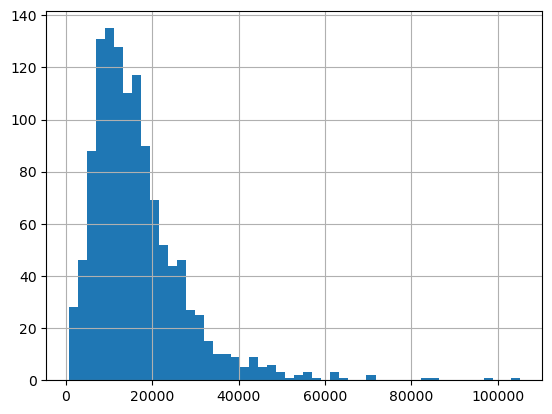

In [19]:
um_norm.number_of_clones.hist(bins=50)

<AxesSubplot:>

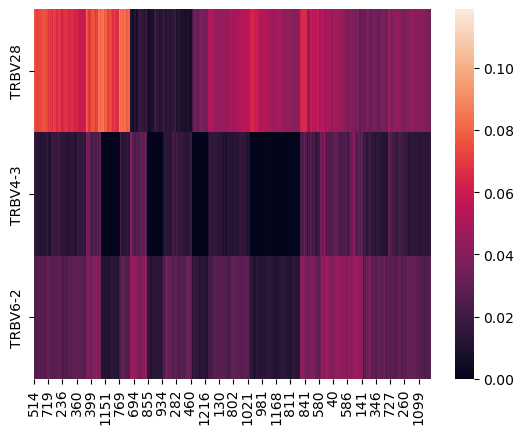

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

genes = ['TRBV28', 'TRBV4-3', 'TRBV6-2']
Z = linkage(um_norm[genes], 'complete')
labels = fcluster(Z, 0.00001, criterion='distance')
labels_order = np.argsort(labels)
sns.heatmap(um_norm.loc[labels_order, :][genes].T)

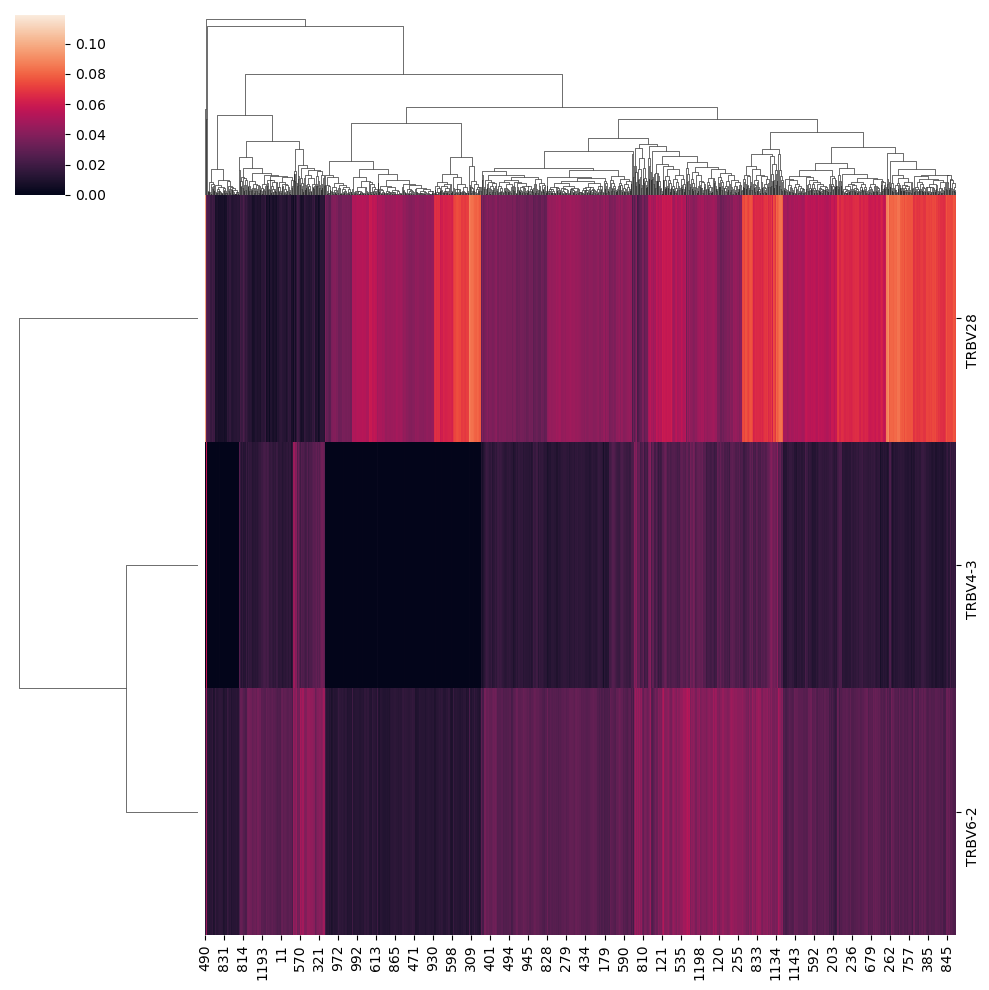

In [21]:
sns.clustermap(um_norm.loc[labels_order, :][genes].T)

# α chain PCA before/after batch effect fixing

In [22]:
um_norm_alpha = prepare_run_column(pd.read_csv('data/normalized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_alpha)
um_stand_alpha = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_alpha)

In [23]:
um_norm_alpha

,run,project,covid,TRAV38-1,TRAV1-2,TRAV28,TRAV13-1,TRAV4,TRAV20,TRAV8-4,...,TRAV41,TRAV8-7,TRAV26-1,TRAV8-5,TRAV3,folder,COVID_status,merged_folder,is_test_run,number_of_clones
0,050002290808_S117_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.012919,0.021619,0.000043,0.044282,0.014094,0.020532,0.038627,...,0.020488,0.0,0.036757,0.002871,0.012180,#2,COVID,#2,False,21854
1,050002630808_S113_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.002914,0.026826,0.000151,0.050638,0.015774,0.015623,0.027931,...,0.021953,0.0,0.041043,0.001256,0.015875,#2,COVID,#2,False,19523
2,050003120808_S112_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.015048,0.022865,0.000293,0.052228,0.017979,0.017344,0.032587,...,0.015976,0.0,0.038988,0.002101,0.021986,#2,COVID,#2,False,20116
3,050003130808_S114_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.005151,0.022840,0.000194,0.044562,0.016668,0.020313,0.028477,...,0.024103,0.0,0.034794,0.002430,0.018661,#2,COVID,#2,False,20234
4,050003450808_S118_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.019996,0.018437,0.000312,0.046493,0.015765,0.018927,0.029659,...,0.022178,0.0,0.040748,0.002806,0.012425,#2,COVID,#2,False,22174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,p18_72_DNA_S88_L002,2021/01_FMBA_NovaSeq9,covid,0.022672,0.020759,0.000022,0.055060,0.014477,0.019607,0.033584,...,0.020563,0.0,0.044170,0.000717,0.011347,#9,COVID,#9,False,45029
1269,p18_73_DNA_S89_L002,2021/01_FMBA_NovaSeq9,covid,0.027998,0.020617,0.000088,0.047088,0.013631,0.019551,0.033643,...,0.028492,0.0,0.042277,0.001131,0.008348,#9,COVID,#9,False,89402
1270,p18_74_DNA_S90_L002,2021/01_FMBA_NovaSeq9,covid,0.037081,0.016861,0.000115,0.038001,0.013157,0.023218,0.027225,...,0.029656,0.0,0.023817,0.001511,0.011687,#9,COVID,#9,False,118975
1271,p18_75_DNA_S91_L002,2021/01_FMBA_NovaSeq9,covid,0.022280,0.019833,0.000096,0.047763,0.014974,0.026197,0.025236,...,0.031225,0.0,0.030845,0.001821,0.006025,#9,COVID,#9,False,213654


In [24]:
um_stand_alpha

,run,project,covid,TRAV38-1,TRAV1-2,TRAV28,TRAV13-1,TRAV4,TRAV20,TRAV8-4,...,TRAV41,TRAV8-7,TRAV26-1,TRAV8-5,TRAV3,is_test_run,folder,COVID_status,merged_folder,number_of_clones
0,050002290808_S117_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.013693,0.022608,0.000090,0.037576,0.008641,0.018661,0.050980,...,0.018102,9.388818e-08,0.033555,0.002567,0.008763,False,#2,COVID,#2,21854
1,050002630808_S113_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.002049,0.032061,0.000134,0.064466,0.013210,0.005694,0.022614,...,0.021611,9.476407e-08,0.044416,0.001458,0.012188,False,#2,COVID,#2,19523
2,050003120808_S112_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.016875,0.027199,0.000167,0.074565,0.020422,0.010257,0.040975,...,0.008728,1.015446e-07,0.042368,0.002355,0.016969,False,#2,COVID,#2,20116
3,050003130808_S114_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.004958,0.026655,0.000150,0.041232,0.016480,0.019123,0.025791,...,0.027368,9.971174e-08,0.030230,0.002515,0.014854,False,#2,COVID,#2,20234
4,050003450808_S118_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.019207,0.015619,0.000157,0.047670,0.013133,0.013937,0.028535,...,0.022016,9.439327e-08,0.043571,0.002555,0.009057,False,#2,COVID,#2,22174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,p18_72_DNA_S88_L002,2021/01_FMBA_NovaSeq9,covid,0.018956,0.027006,0.000046,0.077856,0.017337,0.009536,0.038473,...,0.008861,8.840376e-08,0.054752,0.000436,0.014818,False,#9,COVID,#9,45029
1266,p18_73_DNA_S89_L002,2021/01_FMBA_NovaSeq9,covid,0.021368,0.027383,0.000125,0.055721,0.015376,0.009612,0.039511,...,0.023060,9.040503e-08,0.051778,0.001010,0.012069,False,#9,COVID,#9,89402
1267,p18_74_DNA_S90_L002,2021/01_FMBA_NovaSeq9,covid,0.027750,0.023723,0.000166,0.020727,0.016394,0.023557,0.022003,...,0.029166,1.058087e-07,0.005089,0.001794,0.018045,False,#9,COVID,#9,118975
1268,p18_75_DNA_S91_L002,2021/01_FMBA_NovaSeq9,covid,0.019486,0.026413,0.000133,0.059279,0.019303,0.028462,0.013116,...,0.027593,9.168310e-08,0.017928,0.001927,0.008648,False,#9,COVID,#9,213654


# plotting

In [29]:
fmba_desc_alpha.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0)

COVID_status,COVID,healthy
folder,,
#1,136.0,0.0
#2,117.0,0.0
#3,121.0,0.0
#4,1.0,149.0
#5,70.0,82.0
#6,80.0,70.0
#7,123.0,54.0
#8,156.0,28.0
#9,86.0,0.0


In [30]:
fmba_desc_beta.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0)

COVID_status,COVID,healthy
folder,,
#1,125.0,0.0
#2,103.0,0.0
#3,112.0,0.0
#4,1.0,150.0
#5,66.0,80.0
#6,78.0,69.0
#7,121.0,50.0
#8,156.0,28.0
#9,86.0,0.0


In [25]:
fmba_desc_alpha.merge(fmba_desc_beta, on=['run', 'COVID_status', 'folder']).COVID_status.value_counts()

COVID      848
healthy    376
Name: COVID_status, dtype: int64

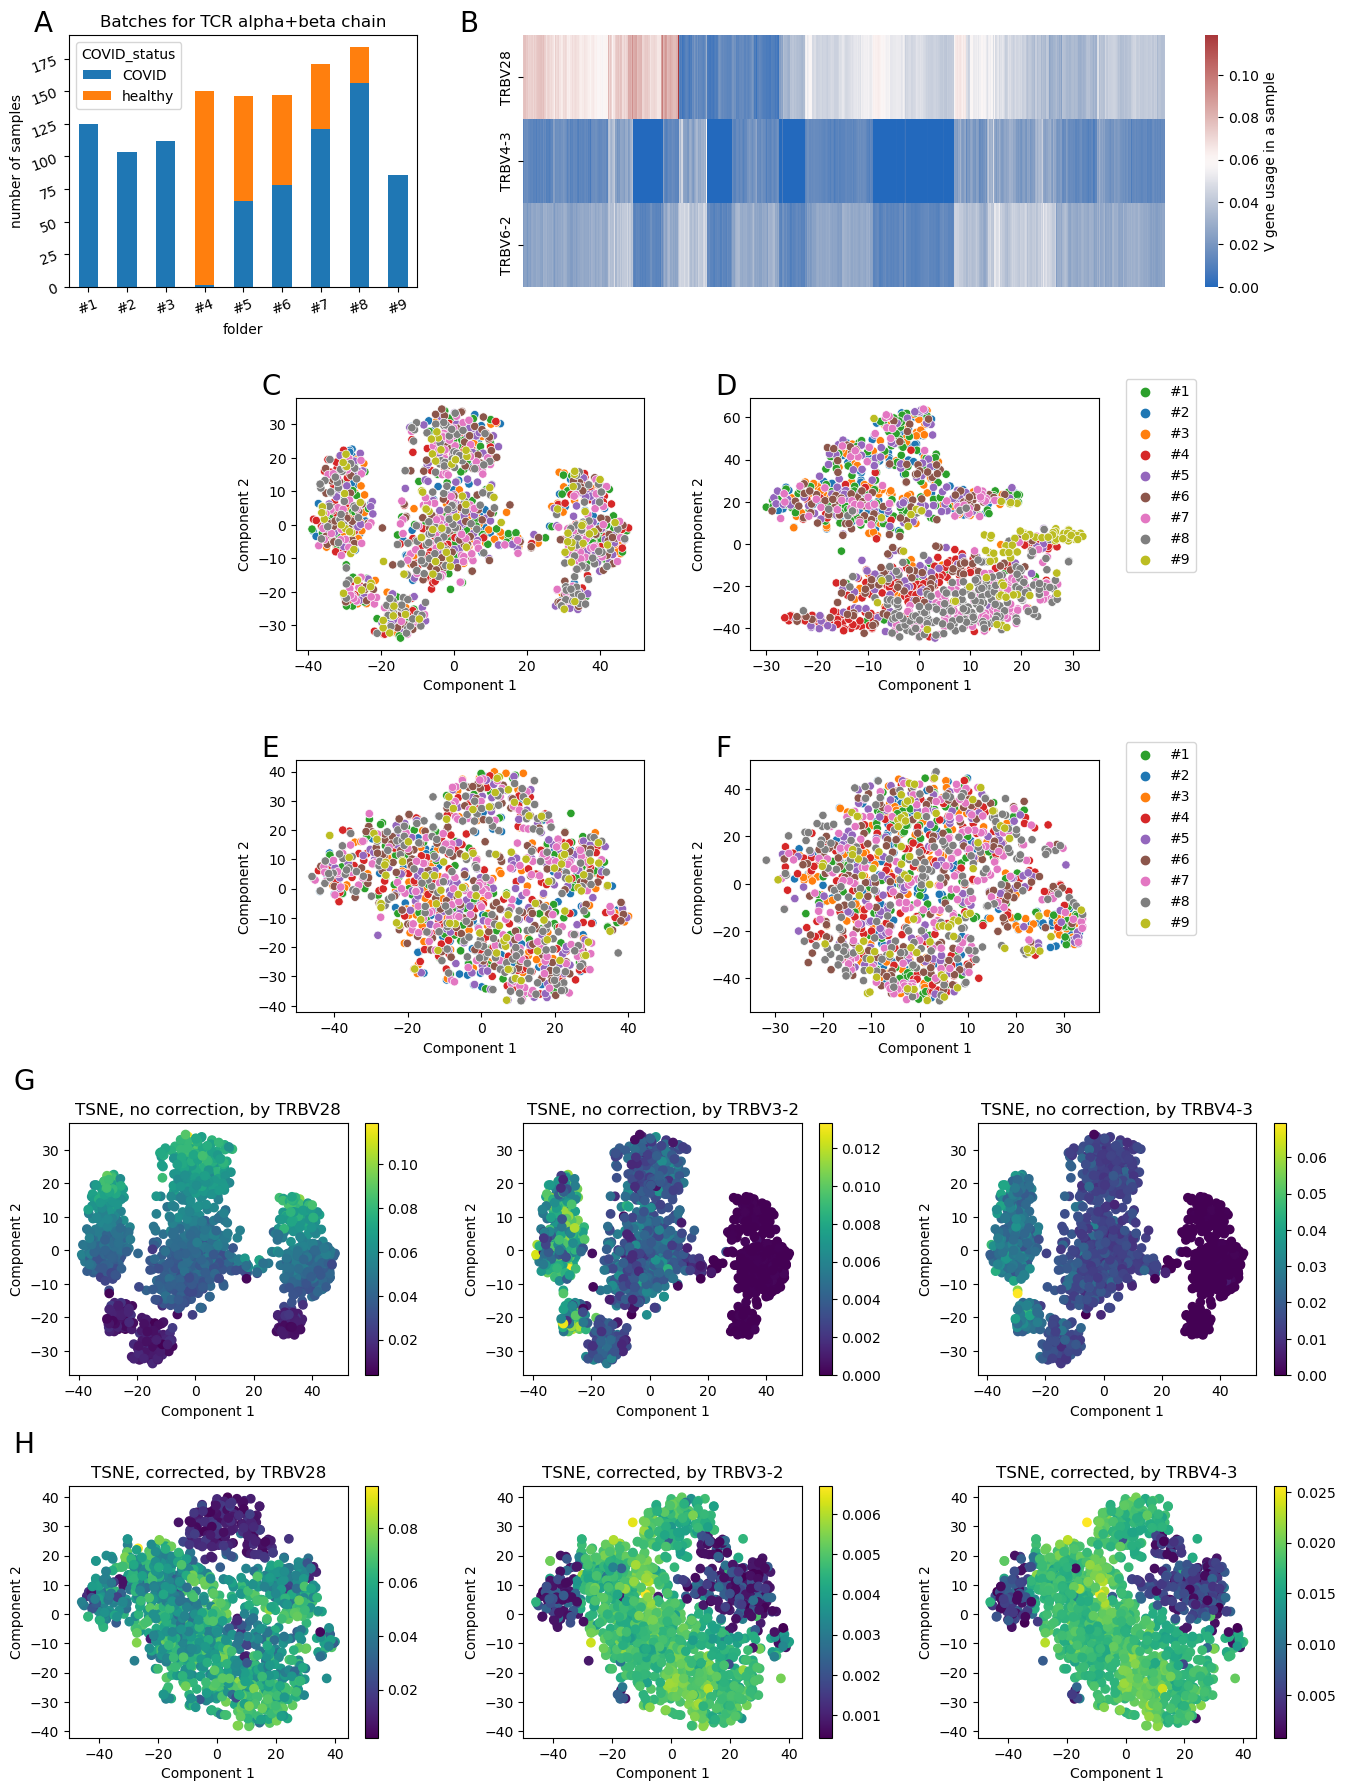

In [53]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(18, 18))
gs = GridSpec(nrows=5, 
              ncols=8)
font_size=20
delta_x=-0.1
delta_y=1.1

# ##############################################################################

# ax0 = fig.add_subplot(gs[0, :2])
# fmba_desc_alpha.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
#                                                                             columns='COVID_status', 
#                                                                             values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax0)
# ax0.set_ylabel('number of samples')
# ax0.set_title('Batches for TCR alpha chain')
# ax0.tick_params(labelrotation=20)
# ax0.text(delta_x, delta_y, 'A',
#      horizontalalignment='left',
#      verticalalignment='top',
#     transform=ax0.transAxes,
#         size=font_size)

# ##############################################################################

# ax12 = fig.add_subplot(gs[0, 2:4])
# fmba_desc_beta.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
#                                                                             columns='COVID_status', 
#                                                                             values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax12)
# ax12.set_ylabel('number of samples')
# ax12.set_title('Batches for TCR beta chain')
# ax12.tick_params(labelrotation=20)
# ax12.text(delta_x, delta_y, 'B',
#      horizontalalignment='left',
#      verticalalignment='top',
#     transform=ax12.transAxes,
#         size=font_size)


##############################################################################

ax13 = fig.add_subplot(gs[0, :2])
fmba_desc_alpha.merge(fmba_desc_beta, on=['run', 'COVID_status', 'folder']).groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax13)
ax13.set_ylabel('number of samples')
ax13.set_title('Batches for TCR alpha+beta chain')
ax13.tick_params(labelrotation=20)
ax13.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax13.transAxes,
        size=font_size)

##############################################################################

ax1 = fig.add_subplot(gs[0, 2:6])
plot_clustermap_axes_based(um_norm, genes=['TRBV28', 'TRBV4-3', 'TRBV6-2'], ax=ax1)
ax1.text(delta_x, delta_y, 'B',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax1.transAxes,
         size=font_size)   

##############################################################################

ax10 = fig.add_subplot(gs[1, 1:3])
plot_usage_matrix_pca(um_norm, target='folder', ax=ax10, method=TSNE)
# ax10.set_title('TSNE for β chain before batch effect fixing')
ax10.legend([],[], frameon=False)
ax10.text(delta_x, delta_y, 'C',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax10.transAxes,
         size=font_size)        

##############################################################################

ax11 = fig.add_subplot(gs[2, 1:3])
plot_usage_matrix_pca(um_stand_log_exp, target='folder', ax=ax11, method=TSNE)
# ax11.set_title('TSNE for β chain after batch effect fixing')
ax11.text(delta_x, delta_y, 'E',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax11.transAxes,
         size=font_size)
ax11.legend([],[], frameon=False)

##############################################################################

ax8 = fig.add_subplot(gs[1, 3:5])
plot_usage_matrix_pca(um_norm_alpha, target='folder', ax=ax8, method=TSNE)
# ax8.set_title('TSNE for α chain before batch effect fixing')
ax8.text(delta_x, delta_y, 'D',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax8.transAxes,
         size=font_size)        

handles, labels = ax8.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax8.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax8, "upper right", bbox_to_anchor=(1.3, 1.1))

##############################################################################

ax9 = fig.add_subplot(gs[2, 3:5])
plot_usage_matrix_pca(um_stand_alpha, target='folder', ax=ax9, method=TSNE)
# ax9.set_title('TSNE for α chain after batch effect fixing')
ax9.text(delta_x, delta_y, 'F',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax9.transAxes,
         size=font_size)
handles, labels = ax9.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax9.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax9, "upper right", bbox_to_anchor=(1.3, 1.1))

##############################################################################

for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[3, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_norm, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, no correction, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'G',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)

##############################################################################
        
for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[4, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_stand_log_exp, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, corrected, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'H',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)
        
##############################################################################

        
plt.tight_layout()
plt.savefig("figures/fig1.svg")
plt.savefig("figures/fig1.pdf")
plt.savefig("figures/fig1.png")
plt.show()

Figure 1. Summary of COVID-19-convalescent and unexposed donor TCR sequencing dataset.

A. Distribution of convalescent and healthy donors across batches.

B. Imprint of TRBV28/3-2/4-3 haplotype on the dataset. Clustering in general is related to TRBV allele deletion.

C, D. Visualization of batch batch effect prior (C) and post (D) correction procedure for TRBV genes. Color shows sample batch. 

E, F. The same as C, D, but for TRAV genes.

G., H. TRBV28/3-2/4-3 haplotype effect remains in place after fixing for batch effect.




# Supplementary Figure 5

In [27]:
um_norm_alpha_j = prepare_run_column(pd.read_csv('data/normalized_usage_matrix_fmba_TRA_j.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_alpha)
um_stand_alpha_j = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRA_j.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_alpha)

In [28]:
um_norm_beta_j = prepare_run_column(pd.read_csv('data/normalized_usage_matrix_fmba_TRB_j.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_beta)
um_stand_beta_j = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRB_j.csv').drop(columns=['Unnamed: 0'])).merge(fmba_desc_beta)

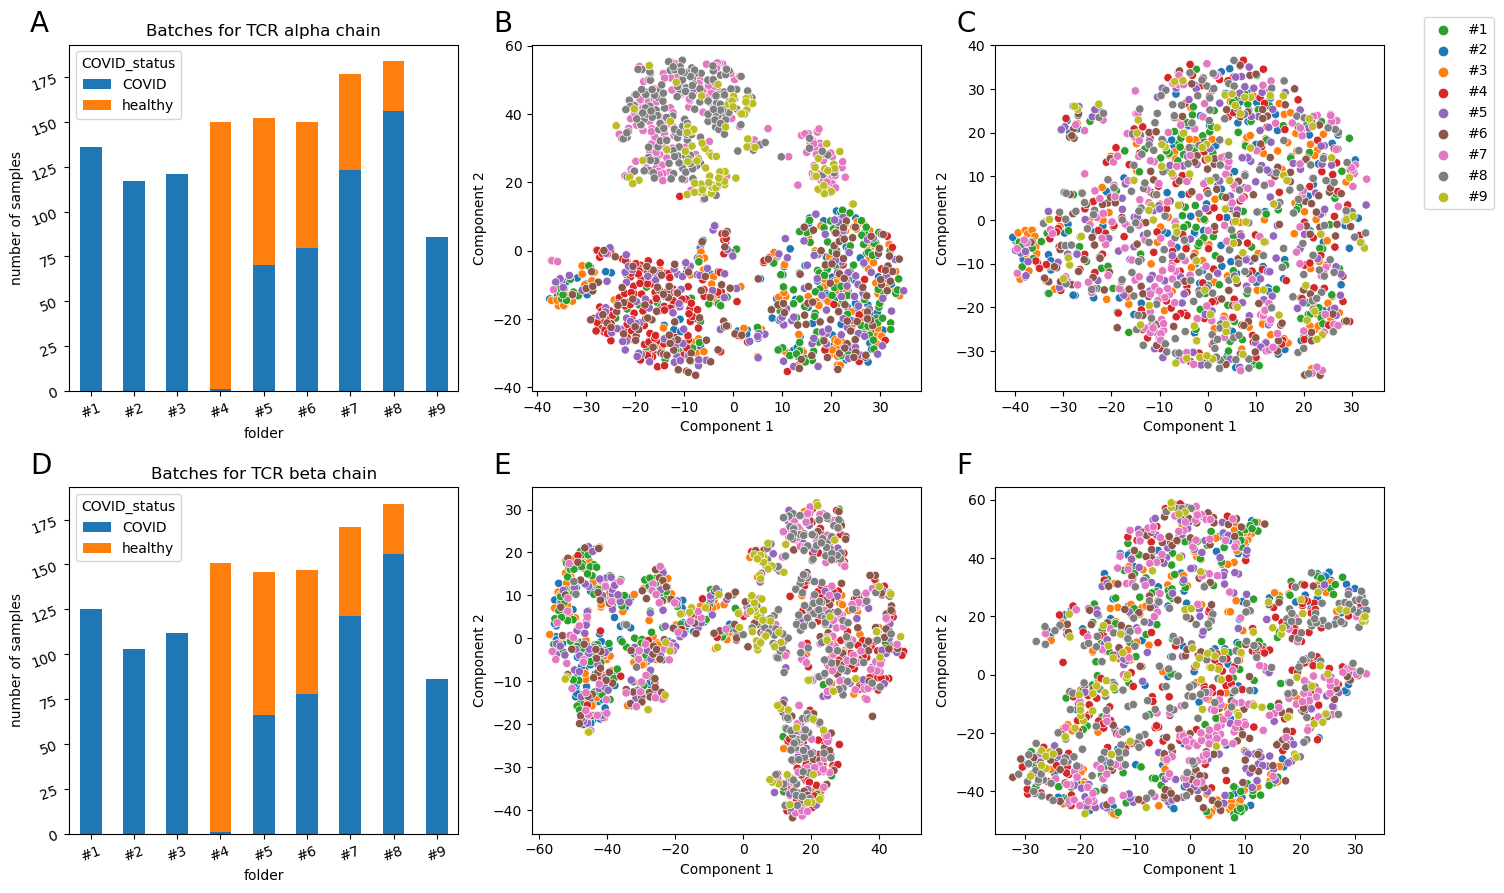

In [34]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 9))
gs = GridSpec(nrows=2, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.1

##############################################################################

ax0 = fig.add_subplot(gs[0, 0])
fmba_desc_alpha.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax0)
ax0.set_ylabel('number of samples')
ax0.set_title('Batches for TCR alpha chain')
ax0.tick_params(labelrotation=20)
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

##############################################################################

ax12 = fig.add_subplot(gs[1, 0])
fmba_desc_beta.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax12)
ax12.set_ylabel('number of samples')
ax12.set_title('Batches for TCR beta chain')
ax12.tick_params(labelrotation=20)
ax12.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax12.transAxes,
        size=font_size)

##############################################################################

ax10 = fig.add_subplot(gs[1, 1])
plot_usage_matrix_pca(um_norm_beta_j, target='folder', ax=ax10, method=TSNE)
# ax10.set_title('TSNE for β chain before batch effect fixing')
ax10.legend([],[], frameon=False)
ax10.text(delta_x, delta_y, 'E',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax10.transAxes,
         size=font_size)        

##############################################################################

ax11 = fig.add_subplot(gs[1, 2])
plot_usage_matrix_pca(um_stand_beta_j, target='folder', ax=ax11, method=TSNE)
# ax11.set_title('TSNE for β chain after batch effect fixing')
ax11.text(delta_x, delta_y, 'F',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax11.transAxes,
         size=font_size)
ax11.legend([],[], frameon=False)

##############################################################################

ax8 = fig.add_subplot(gs[0, 1])
plot_usage_matrix_pca(um_norm_alpha_j, target='folder', ax=ax8, method=TSNE)
# ax8.set_title('TSNE for α chain before batch effect fixing')
ax8.text(delta_x, delta_y, 'B',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax8.transAxes,
         size=font_size)        

handles, labels = ax8.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax8.legend([],[], frameon=False) 

##############################################################################

ax9 = fig.add_subplot(gs[0, 2])
plot_usage_matrix_pca(um_stand_alpha_j, target='folder', ax=ax9, method=TSNE)
# ax9.set_title('TSNE for α chain after batch effect fixing')
ax9.text(delta_x, delta_y, 'C',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax9.transAxes,
         size=font_size)
handles, labels = ax9.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax9.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax9, "upper right", bbox_to_anchor=(1.3, 1.1))

##############################################################################

        
plt.tight_layout()
plt.savefig("figures/supp_fig5.svg")
plt.savefig("figures/supp_fig5.pdf")
plt.savefig("figures/supp_fig5.png")
plt.show()

In [37]:
um_stand_log_exp

,run,project,covid,TRBV5-5,TRBV7-7,TRBV11-3,TRBV29-1,TRBV14,TRBV7-9,TRBV7-1,...,TRBV17,TRBV4-3,TRBV16,TRBV28,TRBV4-1,is_test_run,folder,COVID_status,merged_folder,number_of_clones
0,050002290808_S117_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.013570,0.004574,0.001664,0.026744,0.012842,0.042911,6.667261e-07,...,2.333791e-08,0.002254,0.000002,0.057108,0.029319,False,#2,COVID,#2,9409
1,050002630808_S113_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.004185,0.006531,0.010925,0.026395,0.010938,0.026040,7.415595e-07,...,2.595735e-08,0.018961,0.000003,0.046559,0.013867,False,#2,COVID,#2,9443
2,050003120808_S112_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.011644,0.001631,0.016689,0.014387,0.008160,0.037554,6.640726e-07,...,2.324502e-08,0.007928,0.000002,0.042240,0.025373,False,#2,COVID,#2,10619
3,050003130808_S114_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.009106,0.006611,0.016853,0.025371,0.007986,0.023917,6.630143e-07,...,2.320798e-08,0.002241,0.000002,0.021973,0.024616,False,#2,COVID,#2,8726
4,050003450808_S118_L002,2020/09_FMBA_NovaSeq2_DNA,covid,0.009122,0.002842,0.008086,0.023729,0.017198,0.025521,6.771423e-07,...,2.370251e-08,0.016174,0.000002,0.048258,0.028851,False,#2,COVID,#2,9669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,p18_72_DNA_S88_L002,2021/01_FMBA_NovaSeq9,covid,0.012441,0.003710,0.009320,0.019186,0.015128,0.025437,7.203934e-07,...,2.647665e-08,0.019824,0.000003,0.051665,0.005797,False,#9,COVID,#9,28759
1221,p18_73_DNA_S89_L002,2021/01_FMBA_NovaSeq9,covid,0.009105,0.004912,0.008825,0.027944,0.012896,0.043247,6.606936e-07,...,2.428250e-08,0.017538,0.000005,0.046454,0.007956,False,#9,COVID,#9,53169
1222,p18_74_DNA_S90_L002,2021/01_FMBA_NovaSeq9,covid,0.007265,0.004894,0.009809,0.020590,0.010253,0.061540,6.344383e-07,...,2.331754e-08,0.016386,0.000002,0.006871,0.021692,False,#9,COVID,#9,38918
1223,p18_75_DNA_S91_L002,2021/01_FMBA_NovaSeq9,covid,0.010073,0.004411,0.006432,0.022482,0.008310,0.043713,6.565571e-07,...,2.413047e-08,0.004559,0.000002,0.052571,0.028674,False,#9,COVID,#9,97851


In [38]:
from scipy.stats import mannwhitneyu

In [45]:
def check_significant_genes(data, alpha=0.05):
    significant = []
    healthy_data = data[data.covid == 'healthy']
    ill_data = data[data.covid == 'covid']
    n_genes = len([x for x in healthy_data.columns if x.startswith('TR')])
    for col in healthy_data.columns:
        if col.startswith('TR'):
            if mannwhitneyu(healthy_data[col], ill_data[col])[1] / n_genes < alpha:
                significant.append(col)
    return set(significant)

In [47]:
len(check_significant_genes(um_norm).intersection(um_stand_log_exp))

59

In [52]:
len(check_significant_genes(um_norm_alpha).intersection(um_stand_alpha))

49